In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/users/mjk557/scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *

%load_ext autoreload
%autoreload 2

# Check existing sources

In [2]:
mesh = Mesh(r"/users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc")

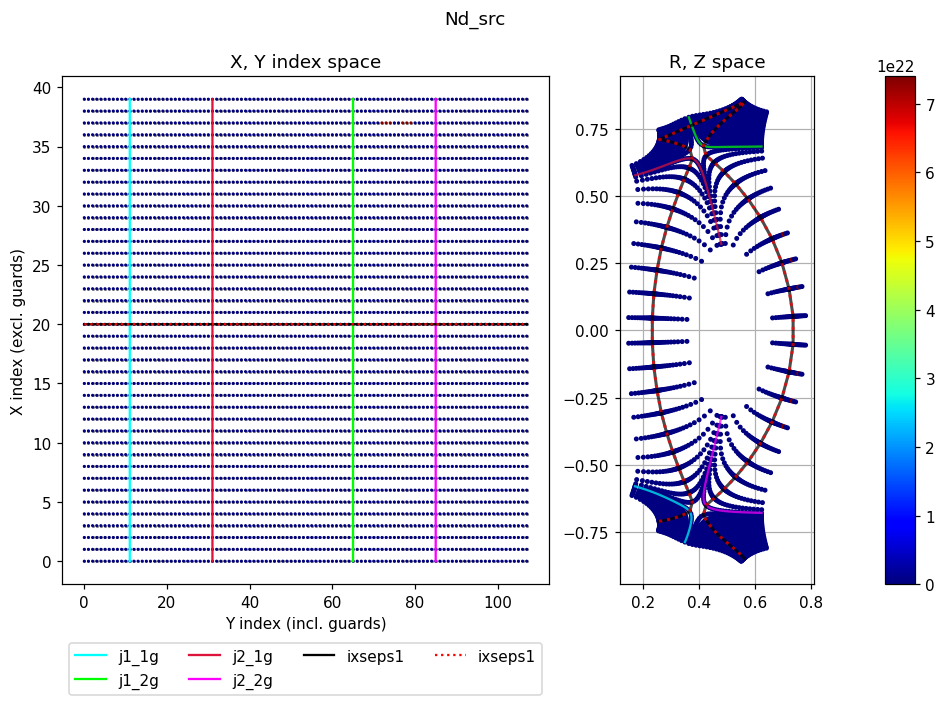

In [3]:
# for field in ['D_e','D_d+','chi_e','chi_d+','Nd_src']:
for field in ['Nd_src']:
    mesh.plot_field(field)

# Source implementation

### Create new mesh file and select the puff region

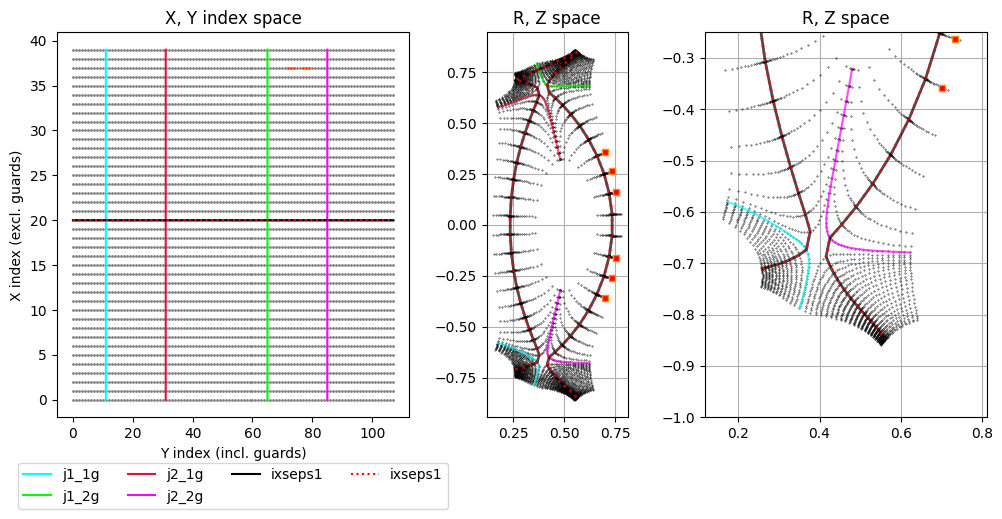

In [2]:
# Ensure you don't have a mesh file already loaded (netCDF caching is problematic)
try:
    mesh.close()
    del mesh
except:
    pass

# Create new grid from an existing one, read it in and create the Field object
shutil.copy(r"/users/mjk557/scratch/cases/g3a5f1-D0.3-Chi0.45.nc", r"/users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc")
mesh = Mesh(r"/users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc")
puff_region_slice = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
mesh.plot_slice(puff_region_slice)

### Create a Field object for neutral energy and neutral density sources

Total pressure source: 0.00e+00 [Pa s-1]
Pressure source per volume: 0.00e+00 [Pa s-1 m-3]
Total density source: 1.20e+21 [Pa s-1]
Density source per volume: 4.44e+23 [Pa s-1 m-3]


/mnt/lustre/users/mjk557/scripts/sdtools/hermes3/grid_fields.py:332: RuntimeWarning: invalid value encountered in true_divide
  fieldnorm = field / np.max(field) * 1


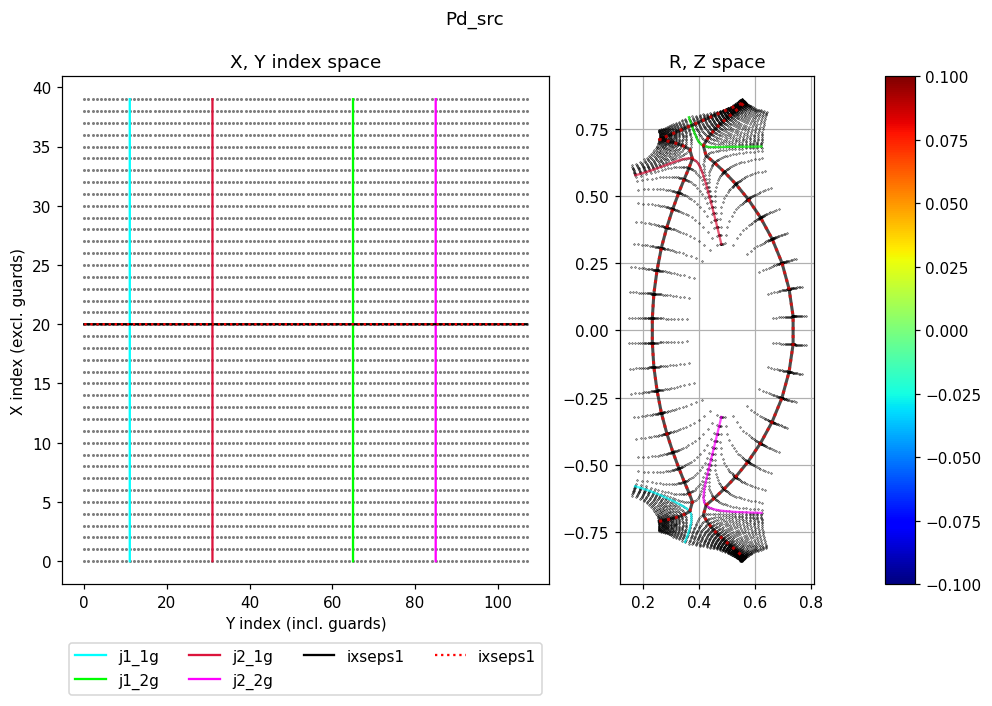

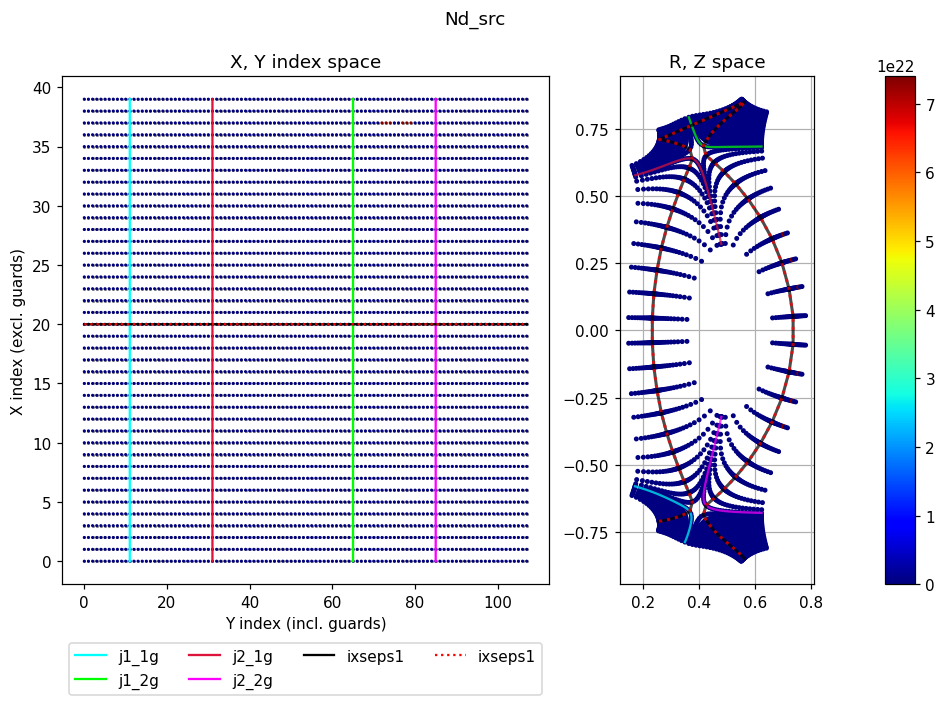

In [3]:
puff_pressure = Field("Pd_src", mesh)
puff_density = Field("Nd_src", mesh)

# Calculate cell volumes
dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

puff_cell_volume = dv[puff_region_slice]   # Array with volume of cells constituting puff

# Pressure source must be in [Pa s] which is [W m-3]
pressure_source = 0   # [W]
pressure_source_per_cell = pressure_source * (puff_cell_volume/puff_cell_volume.sum())   # total [W] divided between cells
pressure_source_per_volume = pressure_source_per_cell/puff_cell_volume   # [W m-3] divided between cells

# Density source is in particles per cubic meter per second 
density_source = 1.2e21 * 1   # [s-1]
density_source_per_cell = density_source * (puff_cell_volume/puff_cell_volume.sum())
density_source_per_volume = density_source_per_cell/puff_cell_volume     # [m-3 s-1]

# Impose sources on the fields
puff_pressure.data[puff_region_slice] = pressure_source_per_volume
puff_density.data[puff_region_slice] = density_source_per_volume

# Check outcome
print(f"Total pressure source: {pressure_source:.2e} [Pa s-1]")
print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [Pa s-1 m-3]")
print(f"Total density source: {density_source:.2e} [Pa s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [Pa s-1 m-3]")
puff_pressure.plot()
puff_density.plot()

### Write to mesh file

In [4]:
# mesh.write_field(puff_pressure)
mesh.write_field(puff_density)

Defining dimension z of size 1
>>> Field Nd_src already exists in /users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc, it will be overwritten
-> Wrote field Nd_src to /users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc


### Double check the fields were written correctly

Mesh file /users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc closed
Total density source: 1.20e+21 [Pa s-1]
Density source per volume: 4.44e+23 [Pa s-1 m-3]


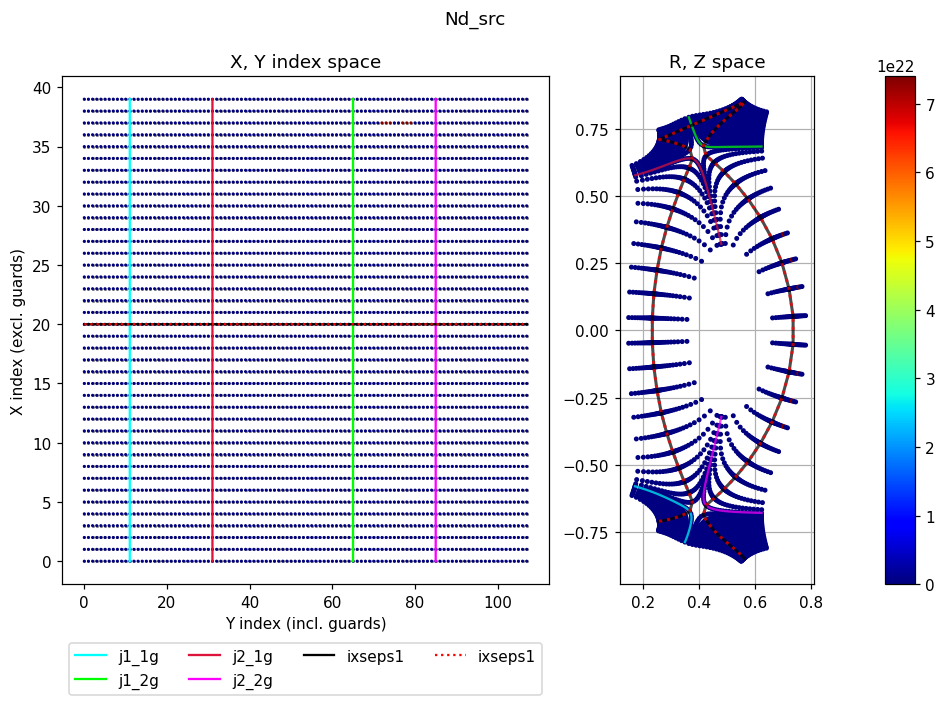

In [9]:
try:
    mesh.close()
    del mesh
except:
    pass

mesh = Mesh(r"/users/mjk557/scratch/cases/g3a5f2-neutpuff1.nc")

# pressure_source_per_volume = mesh.mesh["Pd_src"].squeeze()
density_source_per_volume = mesh.mesh["Nd_src"].squeeze()

dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

# pressure_source = (pressure_source_per_volume * dv).sum()
density_source = (density_source_per_volume * dv).sum()

# print(f"Total pressure source: {pressure_source:.2e} [Pa s-1]")
# print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [Pa s-1 m-3]")
print(f"Total density source: {density_source:.2e} [Pa s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [Pa s-1 m-3]")

mesh.plot_field("Nd_src")

# Run test case

## Verify sources read in by code

In [4]:
db = CaseDB(
    case_dir = r"/users/mjk557/scratch/cases/st40",
    grid_dir = r"/users/mjk557/scratch/cases"
    )

choice = "c4a-puff"

case, caseng = Load.case_2D(db.casepaths[choice], gridfilepath = db.gridpaths["g3a5-fatter.nc"],
                    double_load = True)

/users/mjk557/.local/lib/python3.9/site-packages/xbout/geometries.py:384: UserWarning: rename 't' to 't' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename(t=coordinates["t"])
/users/mjk557/.local/lib/python3.9/site-packages/xbout/geometries.py:384: UserWarning: rename 't' to 't' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename(t=coordinates["t"])
/users/mjk557/.local/lib/python3.9/site-packages/xbout/geometries.py:384: UserWarning: rename 't' to 't' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename(t=coordinates["t"])


--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 1.942E+00 [m3]
--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 1.556E+00 [m3]


{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


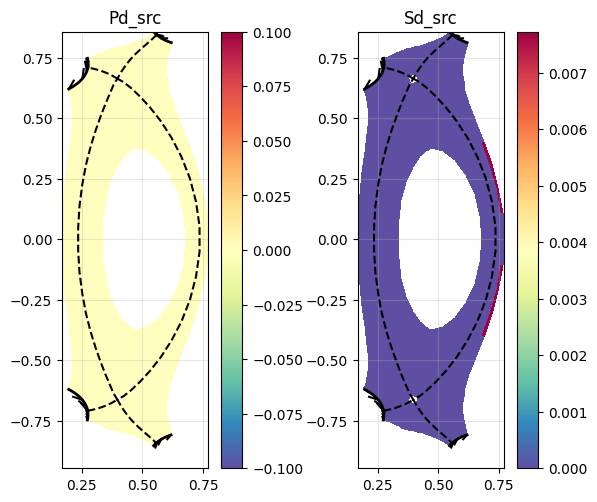

In [5]:
Monitor2D(caseng, mode = "pcolor", windows = [["Pd_src", "Sd_src"]], 
                 settings = {
                    "all":{"view":None, "dpi": 100},
                    "Pd_src":{"log":False},
                    "Sd_src":{"log":False},
                    })

In [13]:
dataset = case.ds.isel(t=-1) # Select final timestep
pressure_source_per_volume = dataset["Pd_src"]
density_source_per_volume = dataset["Sd_src"]

# dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

pressure_source = (pressure_source_per_volume * dataset["dv"]).sum()
density_source = (density_source_per_volume * dataset["dv"]).sum()

print(f"Total pressure source: {pressure_source:.2e} [Pa s-1]")
print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [Pa s-1 m-3]")
print(f"Total density source: {density_source:.2e} [Pa s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [Pa s-1 m-3]")

Total pressure source: 1.00e+04 [Pa s-1]
Pressure source per volume: 1.49e+06 [Pa s-1 m-3]
Total density source: 1.20e+21 [Pa s-1]
Density source per volume: 1.79e+23 [Pa s-1 m-3]


## Verify impact on plasma is as expected

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


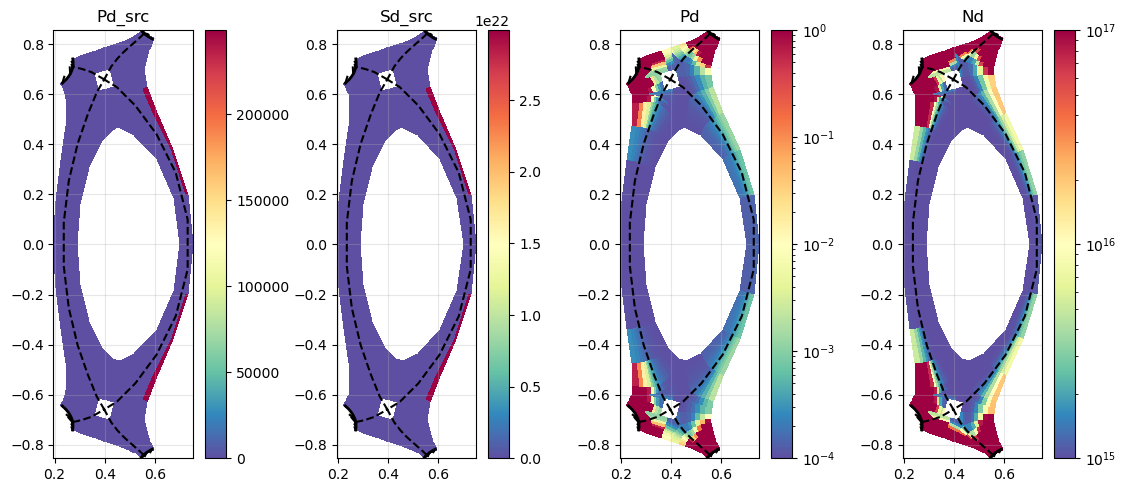

In [19]:
Monitor2D(caseng, mode = "pcolor", windows = [["Pd_src", "Sd_src", "Pd", "Nd"]], 
                 settings = {
                    "all":{"view":None, "dpi": 100},
                    "Pd_src":{"log":False},
                    "Sd_src":{"log":False},
                    "Pd":{"log":True, "vmin":1e-4, "vmax":1e0},
                    "Nd":{"log":True, "vmin":1e15, "vmax":1e17}
                    })